# Natural Language Processing. Assignment 1. Tokenization.

In this assignment, you need to implement, train, and analyze a Byte-Pair Encoding (BPE) tokenizer.

The assignment consist of 3 tasks. When you finish all the tasks, create a GitHub repository for this assignment (you can use this repository later for the other assignments) and submit this notebook in the repository. Leave `requirements.txt` file if your code requires additional installations. Submit the link to the repository in Moodle.

## Task 1: Data Preparation and Vocabulary Size Selection (3 points)

First, load the [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus). After loading the corpus, you need to select the appropriate vocabulary size for the BPE tokenizer. The appropriate vocabulary size is the minimal vocabulary size that covers at least 90% of the words in the corpus. The coverage is calculated according to the following formula:



$$ \text{coverage}(k) = \frac{\sum_{r=1}^{k} f(r)}{\sum_{r=1}^{N} f(r)} $$



where $f(r)$ is the frequency of the top-$r$ word, $k$ is the number of top-$k$ tokens included in vocab, $N$ is the total unique words in corpus.

So, for this task you need to do the following:

1. Load the Brown corpus (0.5 points)
2. Plot cumulative coverage vs. vocabulary size for the loaded corpus (1 point)
3. Select the appropriate vocabulary size (0.5 point)
4. Answer the questions:
    1. Why the coverage slows down the increase as the vocabulary size increases? (0.5 point)
    2. Which empirical law explains the slowing down increase of the coverage? (0.5 point)

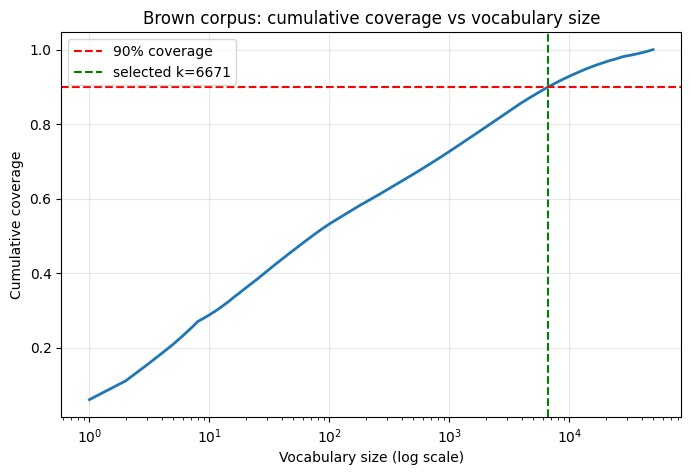

Selected vocabulary size: 6671
Coverage at selected size: 0.9000
Why growth slows down: frequent words are covered first, then mostly rare words remain.
Empirical law: Zipf's law.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import nltk
from nltk.corpus import brown

nltk.download('brown', quiet=True)

brown_words = [word.lower() for word in brown.words() if word.strip()]
word_frequencies = Counter(brown_words)

frequencies = np.array(sorted(word_frequencies.values(), reverse=True), dtype=np.int64)
cumulative_coverage = np.cumsum(frequencies) / frequencies.sum()
vocab_sizes = np.arange(1, len(frequencies) + 1)

selected_vocab_size = int(np.searchsorted(cumulative_coverage, 0.9) + 1)
selected_coverage = float(cumulative_coverage[selected_vocab_size - 1])

plt.figure(figsize=(8, 5))
plt.plot(vocab_sizes, cumulative_coverage, linewidth=2)
plt.axhline(0.9, color='red', linestyle='--', label='90% coverage')
plt.axvline(selected_vocab_size, color='green', linestyle='--', label=f'selected k={selected_vocab_size}')
plt.xscale('log')
plt.xlabel('Vocabulary size (log scale)')
plt.ylabel('Cumulative coverage')
plt.title('Brown corpus: cumulative coverage vs vocabulary size')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f'Selected vocabulary size: {selected_vocab_size}')
print(f'Coverage at selected size: {selected_coverage:.4f}')
print('Why growth slows down: frequent words are covered first, then mostly rare words remain.')
print("Empirical law: Zipf's law.")



## Task 2: Implement Byte-Pair Encoding (BPE) Tokenizer (4 points)

Implement the [BPE tokenizer](https://arxiv.org/pdf/1508.07909) as the `BPETokenizer` class.

The class should contain correctly implemented:

* `train` method (1.5 points).
* `tokenize` method (1.5 points).

The code should have docstrings and comments (1 point).

In [1]:
from collections import Counter
from typing import Dict, List, Tuple


class BPETokenizer:
    def __init__(self, end_of_word: str = "</w>"):
        self.end_of_word = end_of_word
        self.merges: List[Tuple[str, str]] = []
        self.vocab: set[str] = set()
        self.is_trained = False
        self.lowercase = True  # keep train/tokenize consistent

    def _split_word(self, word: str) -> Tuple[str, ...]:
        """Split a word into a tuple of symbols + end_of_word marker."""
        if self.lowercase:
            word = word.lower()
        return tuple(list(word) + [self.end_of_word])

    def _merge_pair_in_symbols(self, symbols: Tuple[str, ...], pair: Tuple[str, str]) -> Tuple[str, ...]:
        """Merge all occurrences of `pair` in a symbol sequence (left-to-right)."""
        out: List[str] = []
        i = 0
        while i < len(symbols):
            if i + 1 < len(symbols) and symbols[i] == pair[0] and symbols[i + 1] == pair[1]:
                out.append(symbols[i] + symbols[i + 1])
                i += 2
            else:
                out.append(symbols[i])
                i += 1
        return tuple(out)

    def _rebuild_vocab(self, split_words: Dict[Tuple[str, ...], int]) -> None:
        """Rebuild vocabulary as the set of all symbols currently present."""
        vocab = set()
        for symbols in split_words.keys():
            for s in symbols:
                vocab.add(s)
        self.vocab = vocab

    def train(self, words: List[str], vocab_size: int) -> None:
        """
        Train BPE merges on a list of words.

        Args:
            words: list of word strings (can include duplicates).
            vocab_size: target vocabulary size (includes characters and merged symbols).
        """
        # Count word frequencies (ignore empty strings)
        word_freq = Counter(w for w in words if w)
        if not word_freq:
            raise ValueError("Training data is empty.")

        # Represent each unique word as a sequence of symbols
        split_words: Dict[Tuple[str, ...], int] = {}
        for w, freq in word_freq.items():
            split_words[self._split_word(w)] = freq

        # Initialize vocab from characters and </w>
        self._rebuild_vocab(split_words)

        # If requested vocab is smaller than the initial one, do no merges (or raise).
        if vocab_size <= len(self.vocab):
            self.merges = []
            self.is_trained = True
            return

        self.merges = []

        # Merge until we reach vocab_size or can no longer merge
        while len(self.vocab) < vocab_size:
            pair_freq = Counter()

            # Count adjacent pairs in all words, weighted by word frequency
            for symbols, freq in split_words.items():
                for i in range(len(symbols) - 1):
                    pair = (symbols[i], symbols[i + 1])
                    pair_freq[pair] += freq

            if not pair_freq:
                break

            best_pair = pair_freq.most_common(1)[0][0]
            self.merges.append(best_pair)

            # Apply this merge to every word
            new_split_words: Dict[Tuple[str, ...], int] = {}
            for symbols, freq in split_words.items():
                merged_symbols = self._merge_pair_in_symbols(symbols, best_pair)
                new_split_words[merged_symbols] = new_split_words.get(merged_symbols, 0) + freq
            split_words = new_split_words

            # Update vocab to reflect new symbols actually present
            self._rebuild_vocab(split_words)

        self.is_trained = True

    def tokenize(self, text: str) -> List[str]:
        """
        Tokenize text into BPE subword units.

        Note: this simple version splits text by whitespace.
        """
        if not self.is_trained:
            raise RuntimeError("Tokenizer is not trained.")

        tokens: List[str] = []

        for word in text.split():
            symbols = self._split_word(word)

            # Apply merges in the learned order
            for pair in self.merges:
                symbols = self._merge_pair_in_symbols(symbols, pair)

            # Remove </w> marker and output tokens
            for s in symbols:
                if s.endswith(self.end_of_word):
                    s = s[: -len(self.end_of_word)]
                if s:
                    tokens.append(s)

        return tokens


## Task 3: Tokenizer Training and Analysis (3 points)

1. Train the `BPETokenizer` on the Brown corpus with the appropriate vocabulary size selected in Task 1 (1 points)
2. Use the Brown corpus (1000 samples) to calculate the mean and standard deviation of
    * tokenizer's fertility (1 points)
    * length of the tokenized sentence (1 points)

In [4]:
tokenizer = BPETokenizer()
tokenizer.train(brown_words, vocab_size=selected_vocab_size)

brown_sentences = brown.sents()[:1000]
fertilities = []
tokenized_lengths = []

for sentence in brown_sentences:
    sentence_words = [word.lower() for word in sentence if word.strip()]

    sentence_text = ' '.join(sentence_words)
    bpe_tokens = tokenizer.tokenize(sentence_text)

    tokenized_lengths.append(len(bpe_tokens))
    fertilities.append(len(bpe_tokens) / len(sentence_words))

fertility_mean = float(np.mean(fertilities))
fertility_std = float(np.std(fertilities))
length_mean = float(np.mean(tokenized_lengths))
length_std = float(np.std(tokenized_lengths))

print(f'Fertility mean: {fertility_mean:.4f}')
print(f'Fertility std: {fertility_std:.4f}')
print(f'Tokenized sentence length mean: {length_mean:.4f}')
print(f'Tokenized sentence length std: {length_std:.4f}')



Fertility mean: 1.2696
Fertility std: 0.2526
Tokenized sentence length mean: 27.3590
Tokenized sentence length std: 15.0934


## Grading Procedure Details

During the grading of the completed assignments, a random set of students will be sampled for the **offline assignment defence**. The defence will be arranged shortly after the assignment submission deadline. The particular date and time will be announced later.

The aim of the assignment defence is to ensure the students understand well their own solutions and know how thier solution works. To check this, the students will be asked various questions about the provided solution. In addition, the students will be asked to run their solution to ensure the solution works without errors.

Examples of questions:

1. How the cumulative coverage is calculated? Why is it called cumulative?
2. What is the rank of a word?
3. How does the BPE tokenizer work? Note: for this question, the students will not be able to see the their own implementation.
4. Why do you consider such vocabulary size appropriate?
5. What is the formula for the fertility of the tokenizer?
6. How do you perform pre-tokenization in your implementation?
7. How do you handle stopwords in the training corpus? Why?
8. etc.

As a result of the assignment defence, the grade for the assignment may be adjusted.